In [1]:
import numpy as np
import cv2
import os 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from random import random
from numpy import zeros, ones, asarray, load, vstack, savez_compressed
from numpy.random import randint 
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Input, Embedding, Concatenate, BatchNormalization, Activation, UpSampling2D, PReLU, add
from matplotlib import pyplot as plt 
from tensorflow.keras.utils import plot_model
from os import listdir
from keras.preprocessing.image import img_to_array, load_img
from datetime import datetime
from keras.models import load_model
from sklearn.utils import resample
from keras.applications.vgg19 import VGG19

In [2]:
def residual_block(ip):
    res_model = Conv2D(64, (3, 3), padding='same')(ip)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1, 2])(res_model)
    res_model = Conv2D(64, (3, 3), padding='same')(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    return add([ip, res_model])

def upscale_block(ip):
    up_model = Conv2D(256, (3, 3), padding='same')(ip)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes=[1, 2])(up_model)
    return up_model

def Generator(gen_ip, n_residual_block):
    layers = Conv2D(64, (9, 9), padding='same')(gen_ip)
    layers = PReLU(shared_axes=[1, 2])(layers)
    
    temp = layers 
    
    for i in range(n_residual_block):
        layers = residual_block(layers)
    layers = Conv2D(64, (3, 3), padding='same')(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers, temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    
    op = Conv2D(3, (9, 9), padding='same')(layers)
    
    return Model(inputs=gen_ip, outputs=op)

def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3, 3), strides=strides, padding='same')(ip)
    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    return disc_model

def Discriminator(disc_ip):
    df = 64 
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df * 2)
    d4 = discriminator_block(d3, df * 2, strides=2)
    d5 = discriminator_block(d4, df * 4)
    d6 = discriminator_block(d5, df * 4, strides=2)
    d7 = discriminator_block(d6, df * 8)
    d8 = discriminator_block(d7, df * 8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df * 16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    
    return Model(disc_ip, validity)

def build_vgg(hr_shape):
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

def Combine(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [3]:
# train_dir = './mirflickr25k/mirflickr25k'

# for img in os.listdir(train_dir + '/mirflickr'):
#     if img[-3:] == 'jpg':
#         img_array = cv2.imread(train_dir + '/mirflickr/' + img)
#         img_array = cv2.resize(img_array, (128, 128))
#         lr_img_array = cv2.resize(img_array, (32, 32))
#         cv2.imwrite(train_dir + '/hr_images/' + img, img_array)
#         cv2.imwrite(train_dir + '/lr_images/' + img, lr_img_array)

In [4]:
n = 500
lr_list = os.listdir('./mirflickr25k/mirflickr25k/lr_images/')[:n]
lr_images = []

for img in lr_list:
    img_lr = cv2.imread('./mirflickr25k/mirflickr25k/lr_images/' + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)
    
hr_list = os.listdir('./mirflickr25k/mirflickr25k/hr_images/')[:n]
hr_images = []

for img in hr_list:
    img_hr = cv2.imread('./mirflickr25k/mirflickr25k/hr_images/' + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)
    
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

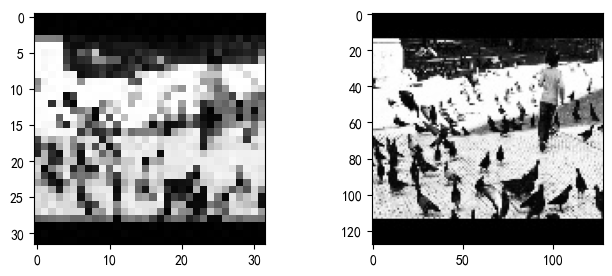

In [5]:
image_number = randint(0, len(lr_images) - 1)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [6]:
lr_images = lr_images / 255.0 
hr_images = hr_images / 255.0

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.3, random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [7]:
generator = Generator(lr_ip, n_residual_block=16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [8]:
discriminator = Discriminator(hr_ip)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [9]:
vgg = build_vgg((128, 128, 3))
vgg.summary()
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [10]:
gan = Combine(generator, discriminator, vgg, lr_ip, hr_ip)
gan.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer='adam')
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [11]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []

for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
epochs = 5 
for epoch in range(epochs):
    fake_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size, 1))
    
    g_losses = []
    d_losses = []
    
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        fake_imgs = generator.predict_on_batch(lr_images)
        
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        discriminator.trainable = False
        
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        
        image_features = vgg.predict(hr_imgs)
        g_loss, _, _ = gan.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    print('Epoch:', epoch + 1, 'g_loss:', g_loss, 'd_loss:', d_loss)
    generator.save('./SRGAN_Generate/Model/gen_e_' + str(epoch + 1) + '.h5')

  0%|          | 0/350 [01:26<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
generator = load_model('./SRGAN_Generate/Model/gen_e_10.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
idx = randint(0, len(X1), 1)
src_image, tar_image = X1[idx], X2[idx]

gen_image = generator.predict(src_image)

plt.figure(figsize=(8, 6))

plt.subplot(1, 3, 1)
plt.title('LR Image')
plt.imshow(src_image[0, :, :, :])
plt.subplot(1, 3, 2)
plt.title('Generated Image')
plt.imshow(gen_image[0, :, :, :])
plt.subplot(1, 3, 3)
plt.title('HR Image')
plt.imshow(tar_image[0, :, :, :])
plt.show()